In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mvtec-ad/readme.txt
/kaggle/input/mvtec-ad/license.txt
/kaggle/input/mvtec-ad/wood/readme.txt
/kaggle/input/mvtec-ad/wood/license.txt
/kaggle/input/mvtec-ad/wood/ground_truth/hole/000_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/003_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/004_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/005_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/001_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/006_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/008_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/007_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/002_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/hole/009_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/000_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/003_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/004_mask.png
/kaggle/input/mvtec-ad/wood/ground_truth/liquid/005_mask.png
/kaggle/input/mvte

In [80]:
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.datasets import ImageFolder
import torch.optim as optim
import os
from torchvision.io import read_image
from PIL import Image


In [168]:
class MVTEC(Dataset):
    def __init__(self,root_dir,train=True,transform=None):
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.image_paths = []

        if self.train:
            normal_dir = os.path.join(root_dir,"train","good")
            for filename in os.listdir(normal_dir):
                if filename.endswith('.png'):
                    self.image_paths.append(os.path.join(normal_dir,filename))
        else:
            for subfolder in os.listdir('/kaggle/input/mvtec-ad/screw/test'): #This will include all subfolders
                test_dir = os.path.join(root_dir,'test',subfolder)
                for filename in os.listdir(test_dir):
                    if filename.endswith('.png'):
                        self.image_paths.append(os.path.join(test_dir,filename))
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image

In [169]:
image_size = 64
transform_func = transforms.Compose([
    # transforms.ToPILImage(), #convert to PIL image to handle transforms
    transforms.Resize(image_size),
    transforms.ToTensor() #convert back to tensor
])

In [170]:
os.listdir('/kaggle/input/mvtec-ad/screw/test')

['good',
 'thread_top',
 'scratch_neck',
 'thread_side',
 'scratch_head',
 'manipulated_front']

In [171]:
os.chdir('/kaggle/input/mvtec-ad')

In [172]:
train_dataset = MVTEC(root_dir='screw',transform=transform_func,train=True)
test_dataset = MVTEC(root_dir='screw',transform=transform_func,train=False)

In [173]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

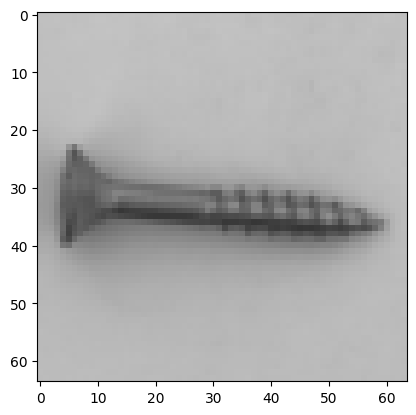

In [174]:
plt.imshow(test_dataset[10].permute(1,2,0).cpu().numpy())

In [184]:
class SimpleEncoder(nn.Module):
    def __init__(self):
        super(SimpleEncoder,self).__init__()
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,3,1,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,1,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,3,1,1),
            nn.Sigmoid(),
        ) 

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [186]:
model = SimpleEncoder().to(device)

In [187]:
model

SimpleEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

In [188]:
#hyper param
optimizer = optim.Adam(model.parameters(),lr = 1e-03)
loss_fn = nn.MSELoss()
epochs = 10

In [189]:
next(iter(train_loader)).shape

torch.Size([32, 3, 64, 64])

In [190]:
# train_losses = []
# for epoch in range(epochs):
#     model.train()
#     train_loss = 0
#     for images,_ in train_loader:
#         images = images.to(device)
#         pred = model(images)
#         loss = loss_fn(pred,images)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#         train_loss += loss.item()
#     avg_loss = train_loss/len(train_loader)
#     print(f'Epoch: {epoch} | Loss: {avg_loss}')
        

In [191]:
train_dataset[0]

tensor([[[0.8431, 0.8431, 0.8471,  ..., 0.8824, 0.8902, 0.8902],
         [0.8392, 0.8392, 0.8392,  ..., 0.8824, 0.8863, 0.8863],
         [0.8353, 0.8353, 0.8353,  ..., 0.8824, 0.8824, 0.8863],
         ...,
         [0.8510, 0.8510, 0.8471,  ..., 0.8627, 0.8627, 0.8588],
         [0.8510, 0.8510, 0.8510,  ..., 0.8588, 0.8588, 0.8588],
         [0.8510, 0.8471, 0.8510,  ..., 0.8627, 0.8588, 0.8588]],

        [[0.8431, 0.8431, 0.8471,  ..., 0.8824, 0.8902, 0.8902],
         [0.8392, 0.8392, 0.8392,  ..., 0.8824, 0.8863, 0.8863],
         [0.8353, 0.8353, 0.8353,  ..., 0.8824, 0.8824, 0.8863],
         ...,
         [0.8510, 0.8510, 0.8471,  ..., 0.8627, 0.8627, 0.8588],
         [0.8510, 0.8510, 0.8510,  ..., 0.8588, 0.8588, 0.8588],
         [0.8510, 0.8471, 0.8510,  ..., 0.8627, 0.8588, 0.8588]],

        [[0.8431, 0.8431, 0.8471,  ..., 0.8824, 0.8902, 0.8902],
         [0.8392, 0.8392, 0.8392,  ..., 0.8824, 0.8863, 0.8863],
         [0.8353, 0.8353, 0.8353,  ..., 0.8824, 0.8824, 0.

In [193]:
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        # print(pred.shape)
        # print(batch.shape)
        loss = loss_fn(pred,batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_loss = train_loss/len(train_loader)
    print(f'Epoch: {epoch} | Loss: {avg_loss}')

Epoch: 0 | Loss: 0.028287693858146667
Epoch: 1 | Loss: 0.014699030946940184
Epoch: 2 | Loss: 0.01168813295662403
Epoch: 3 | Loss: 0.007874741777777671
Epoch: 4 | Loss: 0.004150704201310873
Epoch: 5 | Loss: 0.0028208042029291393
Epoch: 6 | Loss: 0.002168031083419919
Epoch: 7 | Loss: 0.0016273790621198713
Epoch: 8 | Loss: 0.0010223510791547597
Epoch: 9 | Loss: 0.0006646025169175119


In [197]:
transform_func

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [204]:
def classify_single_image(model, image_path, device, transform_func, threshold):
    model.eval() #Set model to evaluation mode.

    image = Image.open(image_path).convert("RGB"). # Open and convert the image to RGB.
    print(type(image))
    # image = transform(image).unsqueeze(0).to(device) # Preprocess the image and send to correct device.
    image = transform(image)
    with torch.no_grad(): #No gradient tracking required for evaluation.
        reconstructed_image = model(image) #Pass image through the model.
        mse = torch.mean((reconstructed_image - image)**2).item() #Calculate the reconstruction error.
        print(f"Reconstruction MSE: {mse:.4f}")
        if mse > threshold: # Threshold using the calculated threshold value.
          print("Anomaly Detected") # Output if anomaly.
          return "anomaly", mse
        else:
          print("Image is normal") # Output if normal.
          return "normal", msea

In [205]:
random_image_path = '/kaggle/input/mvtec-ad/screw/test/scratch_neck/000.png'
threshold = 0.05

In [206]:
classify_single_image(model, random_image_path, device, transform, threshold)


<class 'PIL.Image.Image'>


TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.